#### 查看视频信息

In [1]:
# 查看下载视频的信息
def get_video_info(video_path):
    
    # 提取视频信息
    video_info = sv.VideoInfo.from_video_path(video_path)
    
    # 通过将总帧数除以帧率并四舍五入到最近的一秒来计算视频长度
    video_length = timedelta(seconds = round(video_info.total_frames / video_info.fps))
    
    # 打印视频的分辨率、帧率和长度
    print(f"\033[1mVideo Resolution:\033[0m ({video_info.width}, {video_info.height})")
    print(f"\033[1mFPS:\033[0m {video_info.fps}")
    print(f"\033[1mLength:\033[0m {video_length}")

In [2]:
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
from datetime import timedelta
import os
# 查看视频信息
video_path = ('./videos/vehicles.mp4')
get_video_info(video_path)

Video Resolution: (3840, 2160)
FPS: 25
Length: 0:00:22


### 对帧进行注释（包括边界框、标签和计数线）

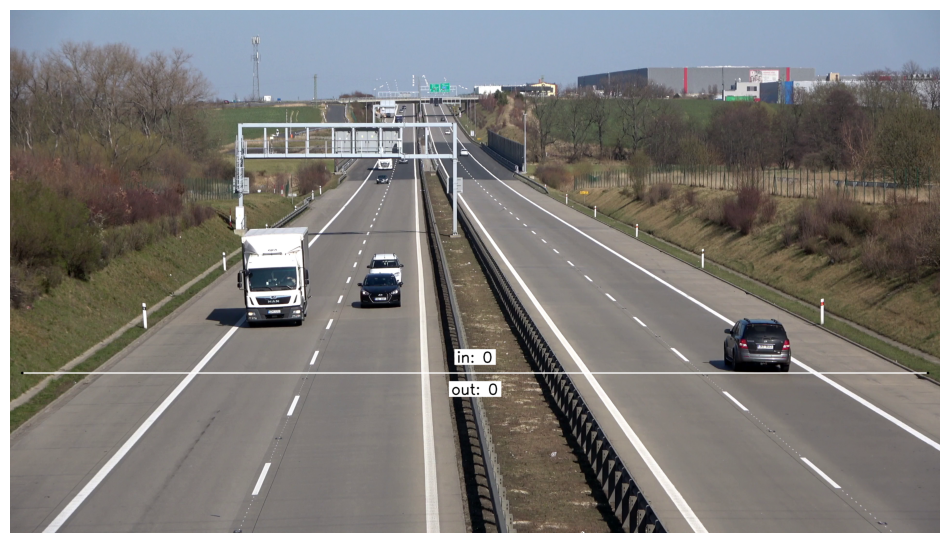

In [3]:
# 定义视频文件路径
video_path = ('./videos/vehicles.mp4')

# 使用视频路径获取视频信息
sv.VideoInfo.from_video_path(video_path)

# 获取视频帧生成器
generator = sv.get_video_frames_generator(video_path)
# 提取第一帧
frame = next(generator)

# 加载YOLO模型
model = YOLO("./weights/yolo11x.pt")
# 使用模型对帧进行推理，获取结果
results = model(frame, verbose=False)[0]
# 从推理结果中提取检测信息
detections = sv.Detections.from_ultralytics(results)

# 根据检测结果生成标签
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

# 创建边界框注释器
bounding_box_annotator = sv.BoxAnnotator(thickness=4)
# 创建标签注释器
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

# 对帧进行注释
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
# 显示注释后的帧

# 定义计数线的起点和终点
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

# 创建线区域对象
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# 创建线区域注释器
line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2)

# 对帧进行线区域注释
annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, LineZoneAnnotator=line_zone)
# 显示注释后的帧
sv.plot_image(annotated_frame, (12, 12))

In [18]:
# 初始化字节追踪器
byte_tracker = sv.ByteTrack()

# 初始化边界框注释器，设置边界框的厚度
bounding_box_annotator = sv.BoxAnnotator(thickness=4)
# 初始化标签注释器，设置标签文本的厚度和比例
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
# 初始化轨迹注释器，设置轨迹的厚度
trace_annotator = sv.TraceAnnotator(thickness=4)

def callback(frame: np.ndarray, index:int) -> np.ndarray:
    """
    回调函数，处理每一帧视频。
    
    参数:
        frame: 当前视频帧。
        index: 当前帧的索引。
    
    返回:
        处理后的视频帧。
    """
    # 使用模型处理当前帧，获取结果
    results = model(frame, verbose=False)[0]
    # 从结果中提取检测信息
    detections = sv.Detections.from_ultralytics(results)
    # 使用字节追踪器更新检测信息
    detections = byte_tracker.update_with_detections(detections)

    # 生成标签列表，包含每个检测对象的追踪ID、类别和置信度
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    # 复制当前帧，用于绘制注释
    annotated_frame = frame.copy()
    # 使用轨迹注释器在帧上绘制轨迹
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    # 使用边界框注释器在帧上绘制边界框
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    # 使用标签注释器在帧上绘制标签
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # 触发线区域检测
    line_zone.trigger(detections)
    
    # 更新进度条
    progress_bar(index)

    # 返回绘制了线区域的帧
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# 设置目标视频路径
TARGET_VIDEO_PATH = "count-objects-crossing-the-line-result.mp4"

# 处理视频，将源视频路径、目标视频路径和回调函数作为参数
sv.process_video(
    source_path = video_path,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)